- Libraries

In [1]:
import pandas as pd
import numpy as np
from DateTime import DateTime
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy as dc
# from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
# from statsmodels.tsa.stattools import adfuller
# from sklearn.metrics import mean_squared_error
# from statsmodels.tools.eval_measures import rmse
# from sklearn import metrics
import warnings

warnings.filterwarnings("ignore")
from src.functions_torch import TransformLag
from src.feature import TimeConfig


In [2]:
df= TimeConfig.process_chain(path='../Data/apple.csv',columns=['Close/Last'])


In [3]:
df

,Value
Date,
2014-05-30,22.6072
2014-06-02,22.4518
2014-06-03,22.7693
2014-06-04,23.0293
2014-06-05,23.1197
...,...
2024-05-22,190.9000
2024-05-23,186.8800
2024-05-24,189.9800


In [4]:
df= df.loc['2023':'2024'].copy()

In [5]:
df


,Value
Date,
2023-01-03,125.07
2023-01-04,126.36
2023-01-05,125.02
2023-01-06,129.62
2023-01-09,130.15
...,...
2024-05-22,190.90
2024-05-23,186.88
2024-05-24,189.98


- Plotting the Data

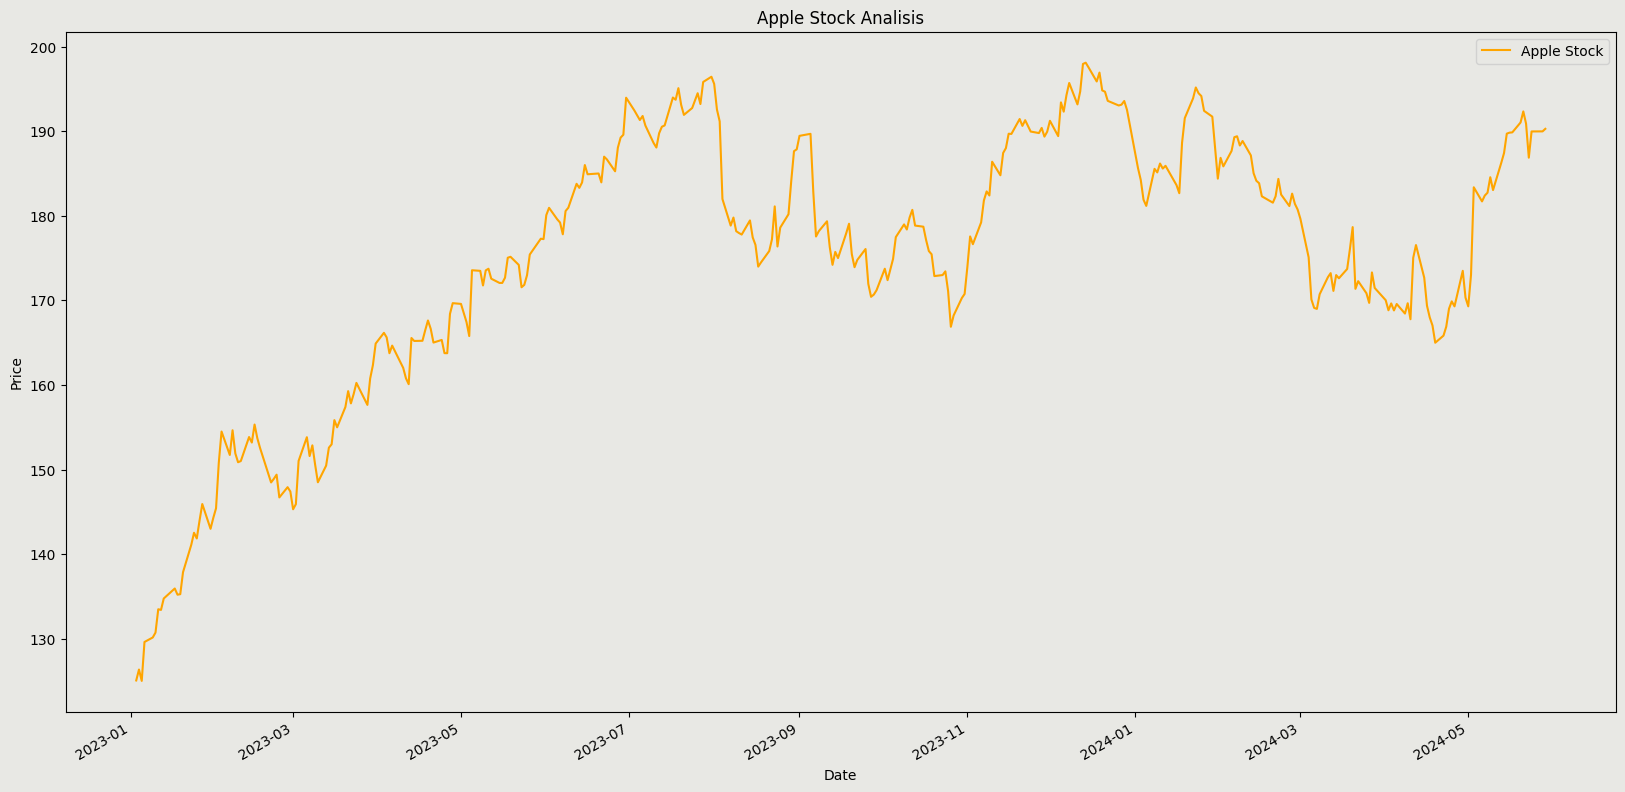

In [6]:
df["Value"].plot(figsize=(20,10),label="Apple Stock",color="orange")
plt.title("Apple Stock Analisis")
plt.xlabel("Date")
plt.ylabel("Price")
plt.gca().set_facecolor("#E8E8E4")
plt.gcf().set_facecolor("#E8E8E4")
plt.legend(facecolor="#E8E8E4")
plt.show()

In [7]:
data= TransformLag.lag_transform(df,7)

In [8]:
data= data.to_numpy()

- Escalado de valores del array entre -1,1 para alimentar el modelo

In [9]:
scaler= MinMaxScaler(feature_range=(-1,1))
transformed= scaler.fit_transform(data)

- Haciendo Slicing para dividir el dato de entrenamiento y el target

In [10]:
X= transformed[:,1:]
y= transformed[:,0]
X= dc(np.flip(X,axis=1))
split_index= int(len(X) * 0.90)
X_train= X[:split_index]
X_test= X[split_index:]
y_train= y[:split_index]
y_test= y[split_index:]
X_train= X_train.reshape((-1,7,1))
X_test= X_test.reshape((-1,7,1))
y_train= y_train.reshape((-1,1))
y_test= y_test.reshape((-1,1))
X_train= torch.tensor(X_train).float()
X_test= torch.tensor(X_test).float()
y_train= torch.tensor(y_train).float()
y_test= torch.tensor(y_test).float()

In [11]:
class TimeSeries(Dataset):
    def __init__(self,X,y):
        self.X= X
        self.y= y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self,i):
        return self.X[i],self.y[i]

batch_size =16
train_dataset= TimeSeries(X_train,y_train)
test_dataset= TimeSeries(X_test,y_test)

train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

In [12]:
for _,batch in enumerate(train_loader):
    x_batch,y_batch= batch[0].to(device),batch[1].to(device)
    print(x_batch.shape,y_batch.shape)
    break

class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,num_stacked_layers):
        super().__init__()
        self.hidden_size= hidden_size
        self.num_stacked_layers= num_stacked_layers
        
        self.lstm= nn.LSTM(input_size,hidden_size,num_stacked_layers,
                           batch_first=True)
        self.fc= nn.Linear(hidden_size,1)
        
    def forward(self,x):
        batch_size= x.size(0)
        h0= torch.zeros(self.num_stacked_layers,batch_size,self.hidden_size).to(device)
        c0= torch.zeros(self.num_stacked_layers,batch_size,self.hidden_size).to(device)
        
        out,_ = self.lstm(x,(h0,c0))
        out= self.fc(out[:,-1,:])
        return out
    
model= LSTM(1,4,1)
model.to(device)

torch.Size([16, 7, 1]) torch.Size([16, 1])


LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [13]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()
    
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

Epoch: 1

Val Loss: 0.714
***************************************************

Epoch: 2

Val Loss: 0.575
***************************************************

Epoch: 3

Val Loss: 0.454
***************************************************

Epoch: 4

Val Loss: 0.345
***************************************************

Epoch: 5

Val Loss: 0.252
***************************************************

Epoch: 6

Val Loss: 0.180
***************************************************

Epoch: 7

Val Loss: 0.130
***************************************************

Epoch: 8

Val Loss: 0.098
***************************************************

Epoch: 9

Val Loss: 0.072
***************************************************

Epoch: 10

Val Loss: 0.052
***************************************************

Epoch: 11

Val Loss: 0.036
***************************************************

Epoch: 12

Val Loss: 0.026
***************************************************

Epoch: 13

Val Loss: 0.020
**********************

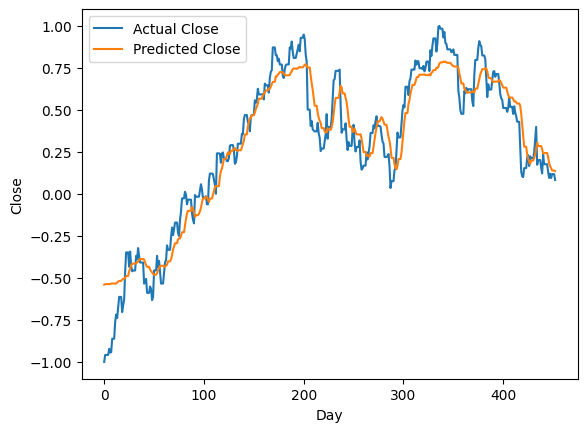

In [14]:
learning_rate = 0.001
num_epochs = 20
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()
    
    with torch.no_grad():
        predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [15]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], 7+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([148.29292944, 148.38758721, 148.38758721, 148.38758721,
       148.38758721, 148.37270143, 148.40554656, 148.49861742,
       148.51665197, 148.51665197, 148.51665197, 148.46886899,
       148.51826974, 148.70325452, 148.87862909, 149.0012517 ,
       149.0012517 , 149.0012517 , 149.24720841, 149.40165227,
       149.43849073, 149.54309806, 149.9607754 , 149.9607754 ,
       149.9607754 , 150.84813776, 151.34403102, 152.02356124,
       152.31410492, 152.34192225, 152.34192225, 152.34192225,
       152.36628036, 152.6240464 , 152.696953  , 153.14357952,
       153.21180924, 153.21180924, 153.21180924, 153.21180924,
       153.13696961, 152.53413396, 152.07199209, 151.71497047,
       151.71497047, 151.71497047, 151.21343527, 150.87707056,
       150.65840958, 150.36357274, 150.20197715, 150.20197715,
       150.20197715, 150.46877975, 151.11387213, 151.49018164,
       151.87968783, 151.92893625, 151.92893625, 151.92893625,
       151.72351629, 151.75358866, 151.94914775, 152.14

In [16]:
dummies = np.zeros((X_train.shape[0], 7+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([133.41      , 134.75999978, 134.75999978, 134.75999978,
       134.75999978, 135.94000082, 135.2099997 , 135.26999982,
       137.87000046, 137.87000046, 137.87000046, 141.10999915,
       142.53000068, 141.85999967, 143.95999997, 145.93000033,
       145.93000033, 145.93000033, 143.        , 144.28999966,
       145.42999998, 150.82000035, 154.50000024, 154.50000024,
       154.50000024, 151.7299999 , 154.64999957, 151.91999996,
       150.86999981, 151.01000041, 151.01000041, 151.01000041,
       153.84999959, 153.19999992, 155.33000027, 153.70999996,
       152.55000024, 152.55000024, 152.55000024, 152.55000024,
       148.48000055, 148.90999915, 149.39999979, 146.70999994,
       146.70999994, 146.70999994, 147.92000008, 147.41000004,
       145.30999974, 145.91000093, 151.0299998 , 151.0299998 ,
       151.0299998 , 153.8300002 , 151.59999997, 152.87000023,
       150.58999958, 148.49999994, 148.49999994, 148.49999994,
       150.4700003 , 152.59      , 152.99000046, 155.85

In [17]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], 7+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([169.41616383, 169.27619216, 168.81747286, 170.34798301,
       170.34798301, 170.34798301, 171.89572171, 172.43137081,
       172.17052445, 171.68534626, 170.84029847, 170.84029847,
       170.84029847, 169.72127225, 168.15705603, 166.88047623,
       166.71614789, 167.15801125, 167.15801125, 167.15801125,
       167.56775014, 169.0994524 , 169.79215615, 170.13341755,
       171.26770556, 171.26770556, 171.26770556, 174.34835647,
       176.45128572, 178.59279459, 180.13671255, 182.01670598,
       182.01670598, 182.01670598, 183.30190054, 184.71888827,
       185.32248364, 186.27269023, 186.9691752 , 186.9691752 ,
       186.9691752 , 187.5100806 , 188.05633485, 188.71021409,
       188.85489349, 188.3875281 , 188.3875281 , 188.3875281 ,
       188.3875281 , 188.55920052, 188.58512145])

In [18]:
dummies = np.zeros((X_test.shape[0], 7+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([169.66999994, 167.78000006, 175.03999971, 176.55000044,
       176.55000044, 176.55000044, 172.6900002 , 169.38000001,
       167.99999993, 167.03999996, 165.00000002, 165.00000002,
       165.00000002, 165.84      , 166.89999996, 169.02000002,
       169.88999981, 169.30000001, 169.30000001, 169.30000001,
       173.49999988, 170.33000004, 169.30000001, 173.03000007,
       183.38000077, 183.38000077, 183.38000077, 181.71000004,
       182.39999947, 182.74000079, 184.56999959, 183.04999915,
       183.04999915, 183.04999915, 186.28000007, 187.4300001 ,
       189.72000045, 189.84000068, 189.86999978, 189.86999978,
       189.86999978, 191.0399992 , 192.35000018, 190.89999957,
       186.87999933, 189.98000032, 189.98000032, 189.98000032,
       189.98000032, 189.99000002, 190.29000061])

- El modelo puede claramente tener una idea de los patrones de los datos pero no de la escala
- El modelo se ha entrenado con datos muy antiguos que no tienen similitud con los datos actuales, habria que repetir el proceso de transformaciones y re-entrenar el modelo con datos mas recientes

In [19]:
print(test_predictions)

[169.41616383 169.27619216 168.81747286 170.34798301 170.34798301
 170.34798301 171.89572171 172.43137081 172.17052445 171.68534626
 170.84029847 170.84029847 170.84029847 169.72127225 168.15705603
 166.88047623 166.71614789 167.15801125 167.15801125 167.15801125
 167.56775014 169.0994524  169.79215615 170.13341755 171.26770556
 171.26770556 171.26770556 174.34835647 176.45128572 178.59279459
 180.13671255 182.01670598 182.01670598 182.01670598 183.30190054
 184.71888827 185.32248364 186.27269023 186.9691752  186.9691752
 186.9691752  187.5100806  188.05633485 188.71021409 188.85489349
 188.3875281  188.3875281  188.3875281  188.3875281  188.55920052
 188.58512145]


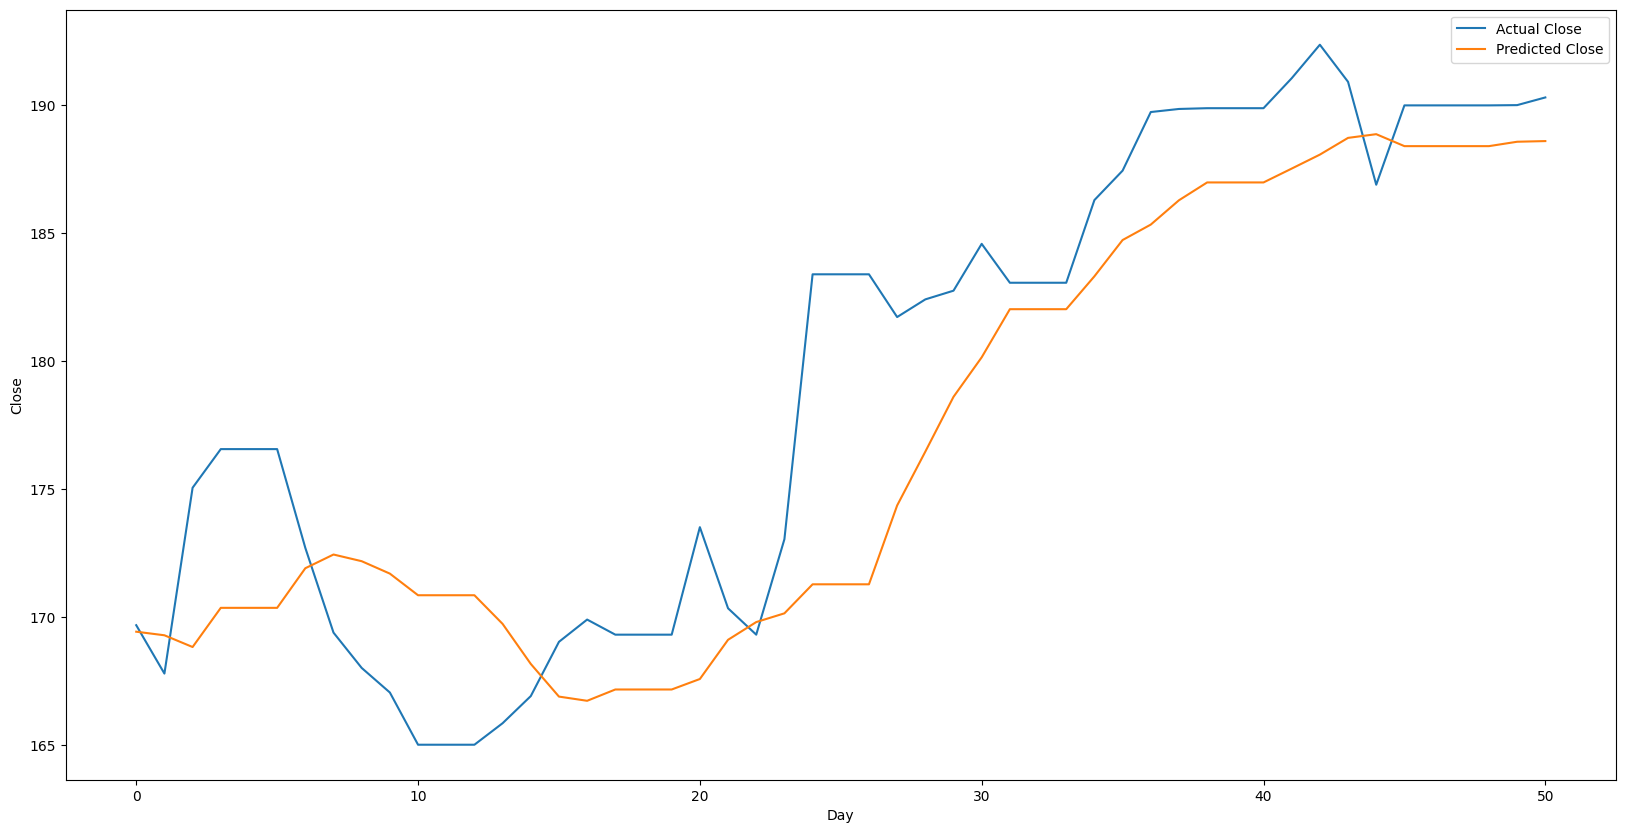

In [20]:
plt.figure(figsize=(20,10))
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()